<a href="https://colab.research.google.com/github/vasanthguna17/sports-image-classifier/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gpiosenka_sports_classification_path = kagglehub.dataset_download('gpiosenka/sports-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'sports-classification' dataset.
Data source import complete.


# import  Libraries

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Phase 1 - Acquisition

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_PATH = '/kaggle/input/sports-classification'

In [ ]:
print("Starting Acquisition Phase...")

# The paper mentions using ImageDataGenerator for batched data importing
train_datagen = ImageDataGenerator(rescale=1./255) # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_ds = train_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load Validation Data
val_ds = test_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'valid'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load Test Data
test_ds = test_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names (e.g., 'basketball', 'football')
class_names = list(train_ds.class_indices.keys())
print(f"Acquisition Complete. Found {len(class_names)} sports categories.")

Starting Acquisition Phase...
Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Acquisition Complete. Found 100 sports categories.


# Phase 2 - Enhancement

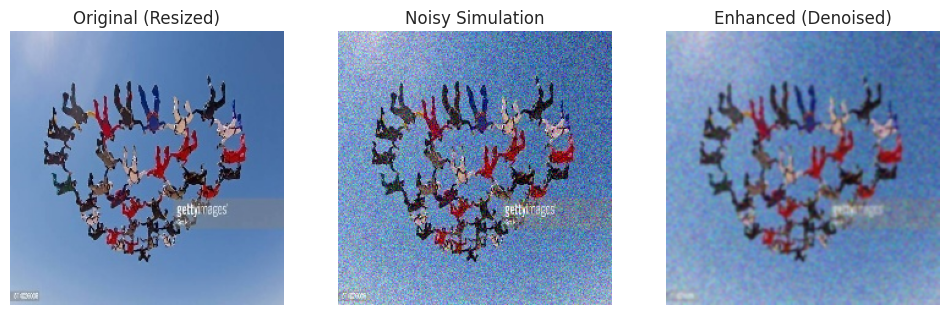

In [ ]:
def display_enhancement_demo():
    # 1. Get a sample image from the generator
    images, labels = next(train_ds)
    sample_img = images[0]

    # 2. Simulate a "Raw" image (Adding noise just for demonstration)
    # In reality, our acquisition already resized it, but let's show the concept
    noisy_img = sample_img + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=sample_img.shape)
    noisy_img = np.clip(noisy_img, 0, 1)

    # 3. Apply Enhancement (Denoising via Gaussian Blur)
    # Note: The neural network does this internally, but we show it explicitly for the course phase.
    enhanced_img = cv2.GaussianBlur(noisy_img, (5, 5), 0)

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original (Resized)")
    plt.imshow(sample_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Noisy Simulation")
    plt.imshow(noisy_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Enhanced (Denoised)")
    plt.imshow(enhanced_img)
    plt.axis('off')

    plt.show()

display_enhancement_demo()

# Phase 3 - Segmentation (The SE Module)

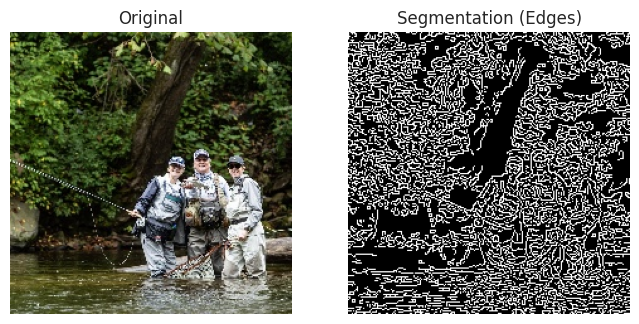

SE Block function defined according to Figure 2 of the paper.


In [ ]:
#  Segmentation (Visual Demo)
def show_segmentation_demo():
    images, _ = next(train_ds)
    img = (images[0] * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Canny Edge Detection
    edges = cv2.Canny(gray, 100, 200)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Segmentation (Edges)")
    plt.axis('off')
    plt.show()

show_segmentation_demo()


# The Paper's "Attention" Segmentation (The SE Block)
# This block tells the network "Look at the athlete, ignore the crowd"
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]

    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(input_tensor)

    # Excitation: Two Fully Connected (Dense) layers
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)

    # Scale: Multiply weights back to input
    return layers.Multiply()([input_tensor, se])

print("SE Block function defined according to Figure 2 of the paper.")

# Data preparation

In [ ]:
def optimize(ds):
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
from IPython.core.display import Path


IMG_SIZE = (224, 224)
BATCH_SIZE = 16


# Load TRAIN dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

# Load VALIDATION dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, "valid"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

# Load TEST dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

# Class names
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)



# Optimize datasets
train_ds = optimize(train_ds)
val_ds   = optimize(val_ds)
test_ds  = optimize(test_ds)


Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


## Phase 4 - Representation (Building the Model)

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))

# ✅ EfficientNetV2 preprocessing INSIDE model
x = preprocess_input(inputs)

base_model = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=x,
    pooling="max"
)

base_model.trainable = True
for layer in base_model.layers[:-33]:
    layer.trainable = False

x = base_model.output

x = layers.BatchNormalization()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.016))(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,711,844 (79.01 MB)

 Trainable params: 2,324,740 (8.87 MB)

 Non-trainable params: 18,387,104 (70.14 MB)

In [ ]:
history = model.fit(
    train_ds, validation_data=val_ds, epochs=20
)


Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 159s 111ms/step - accuracy: 0.0769 - loss: 10.0324 - val_accuracy: 0.4360 - val_loss: 5.7795
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.3026 - loss: 5.6410 - val_accuracy: 0.5980 - val_loss: 3.1818
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.4586 - loss: 3.5512 - val_accuracy: 0.7180 - val_loss: 1.8904
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.5810 - loss: 2.5164 - val_accuracy: 0.8120 - val_loss: 1.2823
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.6623 - loss: 1.9152 - val_accuracy: 0.8620 - val_loss: 0.9649
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.7154 - loss: 1.5973 - val_accuracy: 0.9060 - val_loss: 0.7742
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.7531 - loss: 1.3663 - val_accuracy: 0.9180 - val_loss: 0.6677
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.7894 - loss: 1.2086

In [ ]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
def plot_history(history):


    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(14, 5))

    # ----- Accuracy -----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # ----- Loss -----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


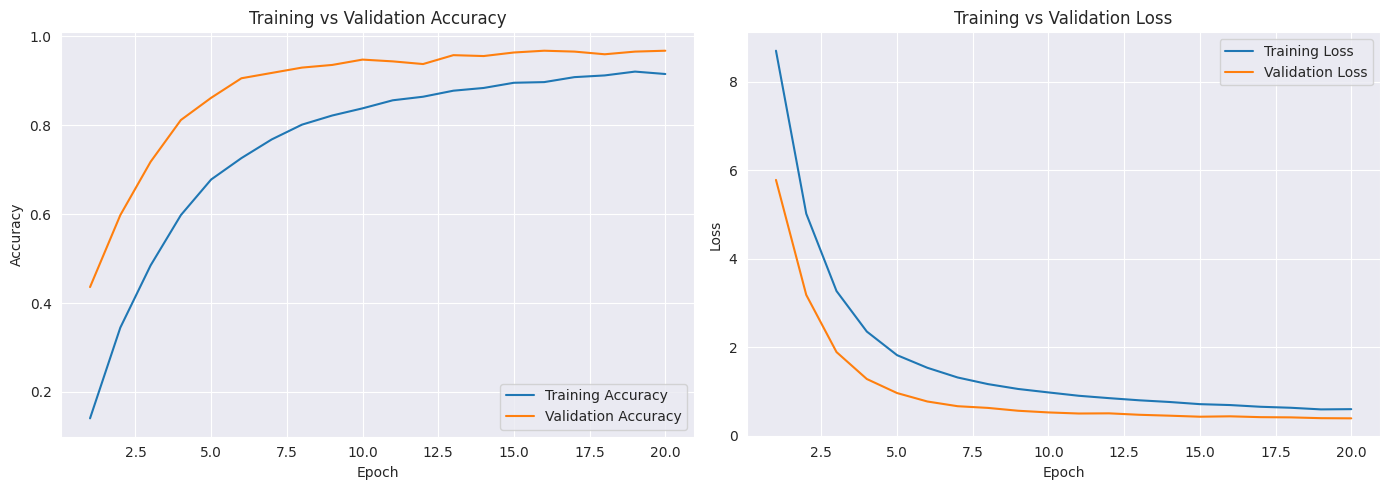

In [ ]:
plot_history(history)

In [ ]:
pred = model.predict(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step


In [ ]:
y_pred = np.argmax(pred, axis=1)
y_true=np.concatenate([y.numpy()for _, y in test_ds])
y_true = np.argmax(y_true, axis=1)


In [ ]:


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix:
 [[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
Classification Report:
                        precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.60      0.75         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                 

In [ ]:


acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.968


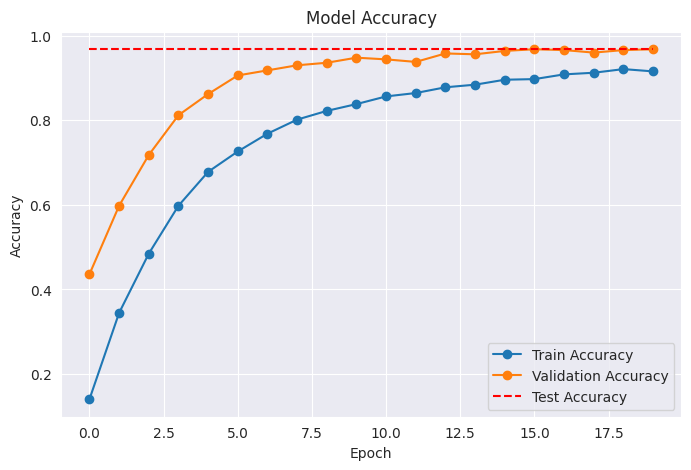

In [ ]:


# 3️⃣ Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, marker='o', label='Train Accuracy')
plt.plot(val_acc, marker='o', label='Validation Accuracy')
plt.hlines(acc, xmin=0, xmax=len(train_acc)-1, colors='r', linestyles='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("model.h5")


In [ ]:
import json

#class_names = train_ds.class_names  # already available

with open("class_names.json", "w") as f:
    json.dump(class_names, f)


In [ ]:
print(class_names)

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 